In [4]:
import numpy as np
from numpy.linalg import norm
from sklearn import linear_model
from sklearn.cluster import KMeans
import bigfloat as bg
import seaborn as sns
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline


In [91]:

priceData=pd.read_csv('priceData.csv',index_col='Date',parse_dates=True,infer_datetime_format=False)
futuresData=pd.read_csv('futures.csv',index_col='日期',parse_dates=True,infer_datetime_format=False)
futuresData.rename(columns={'多方交易口數': 'buyDeals','空方交易口數':'sellDeals','多方未平倉口數':'accBuy','空方未平倉口數':'accSell','日期':'Date'}, inplace=True)

CloseData=priceData['Close']
QFIIData=futuresData[futuresData['身份別']=='外資及陸資'][['buyDeals','sellDeals','accBuy','accSell']]
mergeData=QFIIData.join(CloseData)
prices=mergeData['Close']
v_bid=mergeData['buyDeals']
v_ask=mergeData['sellDeals']
v_accBuy=mergeData['accBuy']
v_accSell=mergeData['accSell']

time1=3
time2=5
time3=8

In [103]:
def generate_timeseries(prices,vbid,vask, n):
    """Use the first time period to generate all possible time series of length n
       and their corresponding label.
    Args:
        prices: A numpy array of floats representing prices over the first time
            period.
        n: An integer (180, 360, or 720) representing the length of time series.
    Returns:
        A 2-dimensional numpy array of size (len(prices)-n) x (n+1). Each row
        represents a time series of length n and its corresponding label
        (n+1-th column).
    """
    m = len(prices) - n
    ts = np.empty((m, n + 2))
    for i in range(m):
        ts[i, :n] = prices[i:i + n]
        ts[i, n]=sum(vbid[i:i+n])/float(sum(vask[i:i+n]))
        ts[i, n+1] = prices[i + n] - prices[i + n - 1]
        #hank add
        ts[i, :n]=(ts[i, :n]-ts[i, :n].mean())/ts[i, :n].mean()
    return ts


def find_cluster_centers(timeseries, k):
    """Cluster timeseries in k clusters using k-means and return k cluster centers.
    Args:
        timeseries: A 2-dimensional numpy array generated by generate_timeseries().
        k: An integer representing the number of centers (e.g. 100).
    Returns:
        A 2-dimensional numpy array of size k x num_columns(timeseries). Each
        row represents a cluster center.
    """
    k_means = KMeans(n_clusters=k,init='k-means++',random_state=42)
    k_means.fit(timeseries)
    #y_kmeans = kmeans.predict(timeseries)
    return k_means.cluster_centers_


def choose_effective_centers(centers, n):
    """Choose n most effective cluster centers with high price variation."""
    return centers[np.argsort(np.ptp(centers, axis=1))[-n:]]


def predict_dpi(x, s):
    """Predict the average price change Δp_i, 1 <= i <= 3.
    Args:
        x: A numpy array of floats representing previous 180, 360, or 720 prices.
        s: A 2-dimensional numpy array generated by choose_effective_centers().
    Returns:
        A big float representing average price change Δp_i.
    """
    num = 0
    den = 0
    
    """
    s: best cluseter
    """
    for i in range(len(s)):
        
        y_i = s[i, len(x)]
        x_i = s[i, :len(x)]
        exp = bg.exp(-0.25 * norm(x - x_i) ** 2)
        num += y_i * exp
        den += exp
    return num / den


def linear_regression_vars(prices, v_bid, v_ask, s1, s2, s3,v_accBuy,v_accSell):
    """Use the second time period to generate the independent and dependent variables
       in the linear regression model Δp = w0 + w1 * Δp1 + w2 * Δp2 + w3 * Δp3 + w4 * r.
    Args:
        prices: A numpy array of floats representing prices over the second time
            period.
        v_bid: A numpy array of floats representing total volumes people are
            willing to buy over the second time period.
        v_ask: A numpy array of floats representing total volumes people are
            willing to sell over the second time period.
        s1: A 2-dimensional numpy array generated by choose_effective_centers()
        s2: A 2-dimensional numpy array generated by choose_effective_centers().
        s3: A 2-dimensional numpy array generated by choose_effective_centers().
    Returns:
        A tuple (X, Y) representing the independent and dependent variables in
        the linear regression model. X is a 2-dimensional numpy array and each
        row represents [Δp1, Δp2, Δp3, r]. Y is a numpy array of floats and
        each array element represents Δp.
    """
    X = np.empty((len(prices) - (time3+1), 4))
   
    Y = np.empty(len(prices) - (time3+1))
    for i in range(time3, len(prices) - 1):
        print prices
        dp = prices[i + 1] - prices[i]
        print prices[i + 1],prices[i],dp
        
        dp1 = predict_dpi(prices[i - time1:i], s1)
        
        dp2 = predict_dpi(prices[i - time2:i], s2)
        dp3 = predict_dpi(prices[i - time3:i], s3)
        #r = (sum(v_bid[i-3:i] - v_ask[i-3:i])) /float (sum(v_bid[i-3:i] + v_ask[i-3:i]))
        r = (sum(v_accBuy[i-3:i] - v_accSell[i-3:i])) /float (sum(v_accBuy[i-3:i] + v_accSell[i-3:i]))
        #r=v_accBuy[i] /float ( v_accSell[i])
        X[i - time3, :] = [dp1, dp2, dp3, r]
        Y[i - time3] = dp
    return X, Y


def find_parameters_w(X, Y):
    """Find the parameter values w for the model which best fits X and Y.
    Args:
        X: A 2-dimensional numpy array representing the independent variables
            in the linear regression model.
        Y: A numpy array of floats representing the dependent variables in the
            linear regression model.
    Returns:
        A tuple (w0, w1, w2, w3, w4) representing the parameter values w.
    """
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    w0 = clf.intercept_
    w1, w2, w3, w4 = clf.coef_
    return w0, w1, w2, w3, w4


def predict_dps(prices, v_bid, v_ask, s1, s2, s3, w,v_accBuy,v_accSell):
    """Predict average price changes (final estimations Δp) over the third
       time period.
    Args:
        prices: A numpy array of floats representing prices over the third time
            period.
        v_bid: A numpy array of floats representing total volumes people are
            willing to buy over the third time period.
        v_ask: A numpy array of floats representing total volumes people are
            willing to sell over the third time period.
        s1: A 2-dimensional numpy array generated by choose_effective_centers()
        s2: A 2-dimensional numpy array generated by choose_effective_centers().
        s3: A 2-dimensional numpy array generated by choose_effective_centers().
        w: A tuple (w0, w1, w2, w3, w4) generated by find_parameters_w().
    Returns:
        A numpy array of floats. Each array element represents the final
        estimation Δp.
    """
    dps = []
    w0, w1, w2, w3, w4 = w
    for i in range(time3, len(prices) - 1):
        dp1 = predict_dpi(prices[i - time1:i], s1)
        dp2 = predict_dpi(prices[i - time2:i], s2)
        dp3 = predict_dpi(prices[i - time3:i], s3)
        r =  (sum(v_accBuy[i-3:i] - v_accSell[i-3:i])) /float (sum(v_accBuy[i-3:i] + v_accSell[i-3:i]))
        #r =  (sum(v_bid[i-3:i] - v_ask[i-3:i])) /float (sum(v_bid[i-3:i] + v_ask[i-3:i]))
        #r=v_accBuy[i] /float ( v_accSell[i])
        dp = w0 + w1 * dp1 + w2 * dp2 + w3 * dp3 + w4 * r
        dps.append(float(dp))
    return dps


def evaluate_performance(prices, dps, t, step):
    """Use the third time period to evaluate the performance of the algorithm.
    Args:
        prices: A numpy array of floats representing prices over the third time
            period.
        dps: A numpy array of floats generated by predict_dps().
        t: A number representing a threshold.
        step: An integer representing time steps (when we make trading decisions).
    Returns:
        A number representing the bank balance.
    """
    bank_balance = 10000
    position = 0
    buyPrice=0
    signal= np.zeros(len(prices) )
   
    
    for i in range(time3, len(prices) - 1, step):
        # long position - BUY
        if dps[i - time3] > t and position <= 0:
            position += 1
            signal[i]=1
            bank_balance -= prices[i]
            buyPrice=prices[i]
            print 'buy ',position,i,prices[i]
        profit=prices[i]-buyPrice
        print i,"profit=",profit
        if profit<-50 and position>0:
            position-=1
            bank_balance += prices[i]
            
            print 'recover',i,prices[i],bank_balance
        # short position - SELL
        if dps[i - time3] < -t and position > 0 :
            position -= 1
            bank_balance += prices[i]
            signal[i]=-1
            
            print 'sell ',position,i,prices[i],bank_balance
    # sell what you bought
    if position == 1:
        bank_balance += prices[len(prices) - 1]
    # pay back what you borrowed
    if position == -1:
        bank_balance -= prices[len(prices) - 1]
    return bank_balance,signal

In [104]:
best_cluster=35
[prices1, prices2, prices3] = np.array_split(prices, 3)
[v_bid1, v_bid2, v_bid3] = np.array_split(v_bid, 3)
[v_ask1, v_ask2, v_ask3] = np.array_split(v_ask, 3)
[v_accBuy1, v_accBuy2, v_accBuy3] = np.array_split(v_accBuy, 3)
[v_accSell1, v_accSell2, v_accSell3] = np.array_split(v_accSell, 3)

timeseries18 = generate_timeseries(prices1,v_bid1,v_ask1, time1)
timeseries36 = generate_timeseries(prices1,v_bid2,v_ask2, time2)
timeseries72 = generate_timeseries(prices1,v_bid3,v_ask3, time3)

centers18 = find_cluster_centers(timeseries18, 150)
s1 = choose_effective_centers(centers18, best_cluster)

centers36 = find_cluster_centers(timeseries36, 150)
s2 = choose_effective_centers(centers36, best_cluster)

centers72 = find_cluster_centers(timeseries72, 150)
s3 = choose_effective_centers(centers72, best_cluster)
Dpi_r, Dp = linear_regression_vars(prices2, v_bid2, v_ask2, s1, s2, s3,v_accBuy2,v_accSell2)
w = find_parameters_w(Dpi_r, Dp)



日期
2013-05-17    8368.19
2013-05-20    8377.05
2013-05-21    8383.05
2013-05-22    8398.84
2013-05-23    8237.83
2013-05-24    8209.78
2013-05-27    8280.10
2013-05-28    8263.05
2013-05-29    8337.90
2013-05-30    8243.29
2013-05-31    8254.80
2013-06-03    8201.02
2013-06-04    8191.22
2013-06-05    8181.91
2013-06-06    8096.14
2013-06-07    8095.20
2013-06-10    8160.55
2013-06-11    8116.15
2013-06-13    7951.66
2013-06-14    7937.74
2013-06-17    7992.89
2013-06-18    8011.02
2013-06-19    8007.39
2013-06-20    7898.91
2013-06-21    7793.31
2013-06-24    7758.03
2013-06-25    7663.23
2013-06-26    7784.80
2013-06-27    7883.90
2013-06-28    8062.21
               ...   
2014-04-09    8930.57
2014-04-10    8948.10
2014-04-11    8908.05
2014-04-14    8857.42
2014-04-15    8916.71
2014-04-16    8923.82
2014-04-17    8944.16
2014-04-18    8966.66
2014-04-21    8951.19
2014-04-22    8974.71
2014-04-23    8956.92
2014-04-24    8945.45
2014-04-25    8774.12
2014-04-28    8809.71
2014-04

In [99]:
print timeseries18[0][0:3]
print timeseries18[0]
print futuresData

[ 0.00564129  0.00815771 -0.013799  ]
[   0.00564129    0.00815771   -0.013799      1.01701411  122.2       ]
              身份別  buyDeals  多方交易契約金額(百萬元)  sellDeals  空方交易契約金額(百萬元)  \
日期                                                                     
2012-05-14    自營商    269294          25691     264771          26242   
2012-05-14     投信       895            521        723           1032   
2012-05-14  外資及陸資     88423          63872      81112          55501   
2012-05-15    自營商    420875          43662     423794          45257   
2012-05-15     投信      1194           1665       1180           1576   
2012-05-15  外資及陸資    133362          75951     113582          73960   
2012-05-16    自營商    424097          49898     469714          53793   
2012-05-16     投信      1783           1433       1004           1229   
2012-05-16  外資及陸資    133815          75497     154957          81721   
2012-05-17    自營商    166103          25120     162744          26184   
2012-05-17     投信        9

In [105]:


# Predict average price changes over the third time period.
dps = predict_dps(prices3, v_bid3, v_ask3, s1, s2, s3, w,v_accBuy3,v_accSell3)
#print dps
# What's your 'Fuck You Money' number?
bank_balance,signal = evaluate_performance(prices3, dps, t=3, step=1)
print bank_balance
#plt.plot( prices3)
pp=np.column_stack((prices3, signal))


8 profit= 9119.96
9 profit= 9140.72
10 profit= 9134.46
11 profit= 9162.74
12 profit= 9222.37
13 profit= 9229.8
14 profit= 9204.65
15 profit= 9196.39
16 profit= 9202.93
17 profit= 9240.6
18 profit= 9279.93
19 profit= 9316.81
20 profit= 9273.79
21 profit= 9228.35
22 profit= 9246.2
buy  1 23 9242.16
23 profit= 0.0
24 profit= 78.78
25 profit= 64.67
26 profit= 150.91
sell  0 26 9393.07 10150.91
27 profit= 199.76
28 profit= 242.8
29 profit= 284.07
30 profit= 267.89
31 profit= 278.04
32 profit= 288.82
33 profit= 247.82
34 profit= 322.96
35 profit= 253.68
36 profit= 278.14
buy  1 37 9569.17
37 profit= 0.0
38 profit= -84.44
recover 38 9484.73 10066.47
39 profit= -160.93
buy  1 40 9400.97
40 profit= 0.0
41 profit= 40.0
42 profit= 98.39
43 profit= 126.57
44 profit= 38.32
sell  0 44 9439.29 10104.79
45 profit= 19.21
46 profit= -9.09
buy  1 47 9447.02
47 profit= 0.0
48 profit= -131.17
recover 48 9315.85 9973.62
buy  1 49 9266.51
49 profit= 0.0
50 profit= 63.68
51 profit= -125.07
recover 51 9141.44 

C:\Users\ktwu\Anaconda2\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(46, 10) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
C:\Users\ktwu\Anaconda2\lib\site-packages\numpy\core\numeric.py:301: FutureWarning: in the future, full(29, -10) will return an array of dtype('int32')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


False
False
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
True
False
True
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False


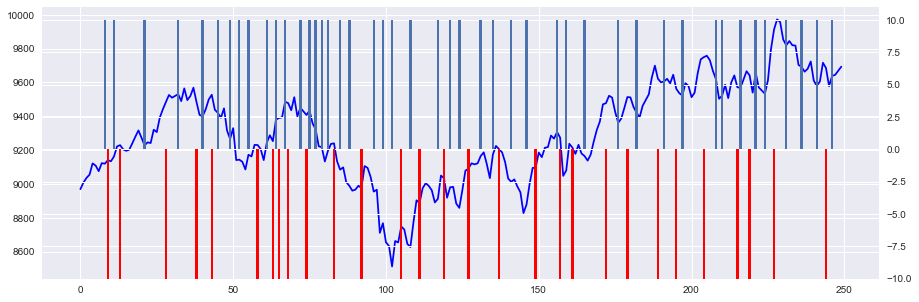

In [9]:

x=np.zeros(len(pp))
for i in range(len(pp)):
    x[i]=i

x1=x[pp[:,1]>0.1]
y1=np.full(len(x1),10)
x2=x[pp[:,1]<0]
y2=np.full(len(x2),-10)

fig,axes=plt.subplots(sharex=True,figsize=(15,5))
plt.plot(x,pp[:,0],color='blue')
ax2=axes.twinx()
plt.bar(x1,y1)
plt.bar(x2,y2,color='red')
#plt.plot(pp[:,1]<0,'ro',color='yellow')
#print "\n".join(map(str,pp[:,0]))
print "\n".join(map(str,pp[:,1]<0))

250


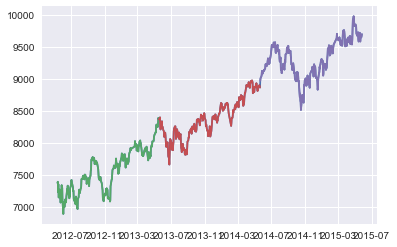

In [10]:
print np.count_nonzero(prices3)

plt.plot(prices)
plt.plot(prices1)
plt.plot(prices2)
plt.plot(prices3)

In [11]:
k_means = KMeans(n_clusters=2)
k_means.fit(timeseries18)
y_kmeans = k_means.predict(timeseries18)

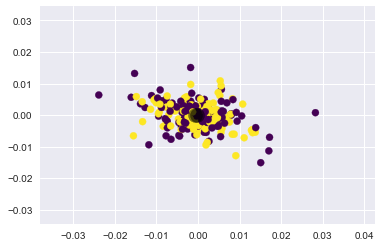

In [12]:
plt.scatter(timeseries18[:, 0], timeseries18[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [13]:
import math

def predict_dpi_1(x, s):
    """Predict the average price change Δp_i, 1 <= i <= 3.
    Args:
        x: A numpy array of floats representing previous 180, 360, or 720 prices.
        s: A 2-dimensional numpy array generated by choose_effective_centers().
    Returns:
        A big float representing average price change Δp_i.
    """
    num = 0
    den = 0
    
    """
    s: best cluseter
    """
    for i in range(len(s)):
    
        y_i = s[i, len(x)]
        
        x_i = s[i, :len(x)]
       # print x_i
        exp = math.exp(-0.25 * norm(x - x_i) ** 2)
        print i,len(x),s[i, len(x)],-0.25 *norm(x - x_i) ** 2, exp
        num += y_i * exp
        den += exp
    return num / den


X = np.empty((len(prices) - 73, 4))
Y = np.empty(len(prices) - 73)

myprices=prices2
for i in range(72, len(myprices) - 1):
        dp = myprices[i + 1] - myprices[i]
        dp1 = predict_dpi(myprices[i - 18:i], s1)
        dp2 = predict_dpi_1(myprices[i - 36:i], s2)
        dp3 = predict_dpi(myprices[i - 72:i], s3)
        
        r = (v_bid[i] - v_ask[i]) / (v_bid[i] + v_ask[i])
        X[i - 72, :] = [dp1, dp2, dp3, r]
        Y[i - 72] = dp
        


IndexError: index 18 is out of bounds for axis 1 with size 4

In [ ]:
 bg.exp(-581093540.02)

In [ ]:
print myprices[73],myprices[72],myprices[73]-myprices[72]
print s1[0]
print np.column_stack((X, Y))

In [ ]:
print timeseries18
print len(timeseries18)
print len(prices1)
print timeseries18.mean()

In [ ]:
timeseries18[0][:-1]-timeseries18[0][:-1].mean()

In [ ]:
print timeseries18[0][:-1],timeseries18[0][:-1].mean()

In [ ]:
n=18
m = len(prices1) - n
ts = np.empty((m, n + 1))
for i in range(m):
        ts[i, :n] = prices[i:i + n]
        ts[i, n] = prices[i + n] - prices[i + n - 1]
        ts[i, :n]=ts[i, :n]-ts[i, :n].mean()
        print ts[i, :n],ts[i, n]

In [ ]:
for i in range(len(s1)):
    print i
    print s1[i]

